<a href="https://colab.research.google.com/github/atlanticstarr1/mnist/blob/main/mnist_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# REFERENCES (REALLY GOOD)
# https://keras.io/examples/vision/consistency_training/
# https://github.com/keras-team/keras-io/blob/master/examples/vision/adamatch.py
# https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/adamatch.ipynb

In [ ]:
#%pip install keras-cv
#%pip install --upgrade tensorflow
#%pip install tensorflow-addons

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras_cv.layers import RandAugment
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
NUM_CLASSES = 10

def Xform(x):
    return x.reshape(-1, 28, 28, 1).astype('float32')/255.0

In [ ]:
def visualize_images(images, labels,columns=5,rows=5):
  labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
  plt.figure(figsize=(2*columns,2*rows))
  for i in range(1, columns * rows+1):
    ax = plt.subplot(rows, columns, i)
    plt.title(labels_map[np.argmax(labels[i])])
    plt.axis("off")
    plt.imshow(images[i],cmap='gray')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
# MNIST
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()

# Names of the integer classes, i.e., 0 -> T-short/top, 1 -> Trouser, etc.
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '']

# split into train validaiton sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2,random_state=1)

In [ ]:
# Add channel dimension and normalize
x_train = Xform(x_train)
x_validate = Xform(x_validate)
x_test =  Xform(x_test)

In [ ]:
# Convert the labels to one-hot encoded vectors
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_validate = np_utils.to_categorical(y_validate, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [ ]:
## Define constants and hyperparameters
RESIZE_TO = 32
BATCH_SIZE = 128
EPOCHS = 10
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
AUTO = tf.data.AUTOTUNE
LEARNING_RATE = 0.03
WEIGHT_DECAY = 0.0005
INIT = "he_normal"

In [ ]:
# Initialize `RandAugment` object with 2 layers of
# augmentation transforms and strength of 5.
augmenter = RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.9)

In [ ]:
def preprocess_train(image):
    # MNIST images are grayscale, this is why we first convert them to
    # RGB images.
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    image = tf.tile(image, [1, 1, 3])
    image = augmenter(image)
    return image

In [ ]:
def preprocess_test(image):
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    image = tf.tile(image, [1, 1, 3])
    return image

In [ ]:
## Data loading utilities
def create_individual_ds(ds, aug_func, shuffle=True):
  if shuffle:
    ds = ds.shuffle(BATCH_SIZE * 10, seed=42)
  ds = ds.map(lambda x, y: (aug_func(x), y), num_parallel_calls=AUTO)
  ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
  return ds

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
train_clean_ds = create_individual_ds(train_ds, preprocess_test)  #no augment
train_noisy_ds = create_individual_ds(train_ds, preprocess_train) #augment
validation_ds = create_individual_ds(validation_ds, preprocess_test,False)
test_ds = create_individual_ds(test_ds, preprocess_test,False)

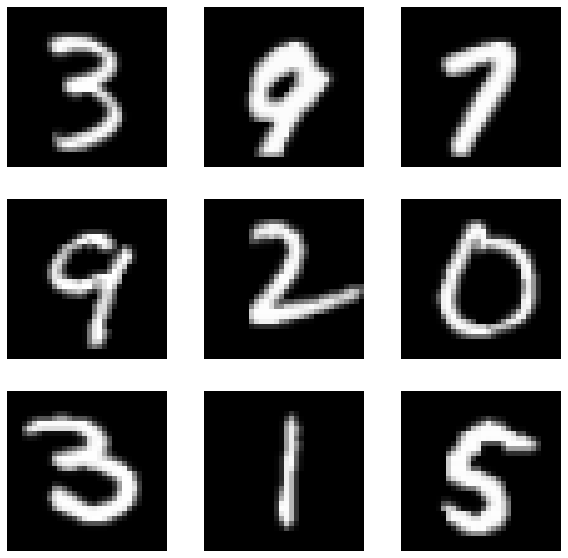

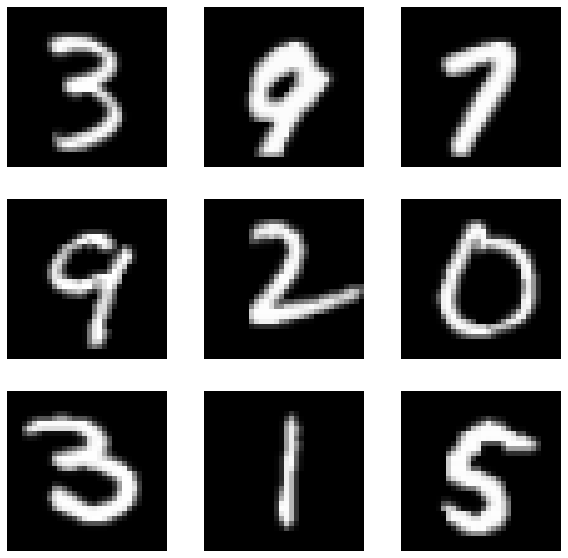

In [ ]:
# Visualize the datasets}
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [ ]:
# Define a model building utility function (ResNet50V2 architecture)
def get_training_model(num_classes=10):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=False, input_shape=(RESIZE_TO, RESIZE_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((RESIZE_TO, RESIZE_TO, 3)),
            layers.Rescaling(scale=1.0 / 255.0),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes),
        ]
    )
    return model

In [ ]:
# save initial weights
initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")

In [ ]:
## TRAIN THE MODEL

# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='my_best_model.epoch{epoch:02d}-accuracy{val_accuracy:.2f}.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Initialize SWA from tf-hub.
SWA = tfa.optimizers.SWA

# Compile and train the teacher model.
teacher_model = get_training_model()
teacher_model.load_weights("initial_teacher_model.h5")
teacher_model.compile(
    # Notice that we are wrapping our optimizer within SWA
    optimizer=SWA(tf.keras.optimizers.Adam()),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history = teacher_model.fit(
    train_noisy_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping,model_checkpoint],
)

Epoch 1/10
 30/375 [=>............................] - ETA: 56s - loss: 1.2554 - accuracy: 0.6227

KeyboardInterrupt: 

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# Evaluate the teacher model on the test set.
_, acc = teacher_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {acc*100}%")